# Generative Model (Wines dataset)

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pymc3 as pm
import arviz as az
import seaborn as sns

az.style.use('arviz-darkgrid')

print('Running on PyMC3 v{}'.format(pm.__version__))

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.7


## Load raw data and plot

In [2]:
# read .csv file into Dataframe
data = pd.read_csv('../../data/wines/FTIR_wines.csv')
data.head(5)

,932.91,936.765,940.62,944.475,948.33,952.1849999999999,956.04,959.895,963.75,967.605,...,4972.95,4976.805,4980.66,4984.515,4988.37,4992.225,4996.08,4999.935,class,label
0,1.270072,1.273169,1.266092,1.258869,1.251778,1.245674,1.236025,1.223376,1.208249,1.192675,...,1.028954,1.029556,1.030253,1.030717,1.031144,1.031782,1.032267,1.032286,1,ARG
1,1.296272,1.288761,1.276294,1.268007,1.259415,1.251337,1.240299,1.227729,1.211221,1.194326,...,1.019150,1.019387,1.020108,1.021605,1.022736,1.022852,1.022512,1.021941,1,ARG
2,1.292655,1.292337,1.284428,1.276734,1.268741,1.261386,1.249830,1.237349,1.222559,1.206709,...,1.052965,1.053167,1.053159,1.053411,1.054176,1.055238,1.055934,1.056007,1,ARG
3,1.300635,1.299655,1.289112,1.280922,1.273402,1.265136,1.252984,1.239267,1.222702,1.205342,...,1.057247,1.057945,1.059025,1.059750,1.060182,1.060698,1.061138,1.060938,1,ARG
4,1.300322,1.288878,1.277027,1.270860,1.265372,1.258198,1.246666,1.234219,1.217923,1.200789,...,1.016039,1.016690,1.017693,1.018515,1.018948,1.019285,1.019412,1.018951,1,ARG


In [3]:
# shuffle data rows
data = data.sample(frac=1, random_state=42)

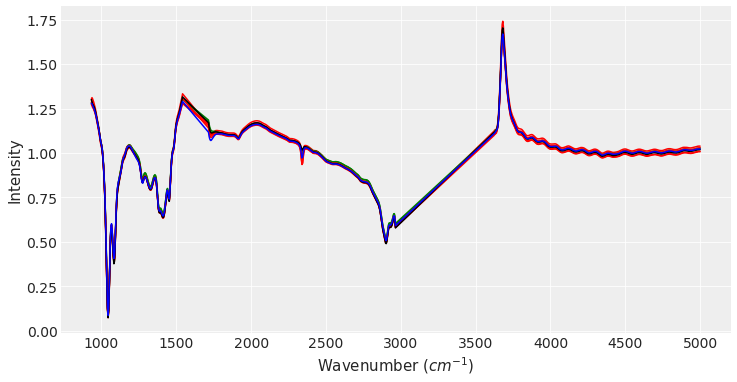

In [15]:
# number of non-data columns at right of dataframe
ndata_cols = -2

# number of classes in data
nclass = 4

# class labels
clabels = ['AUS', 'CHI', 'SOU', 'ARG']

# header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:ndata_cols], dtype='float32')

# plot all data in 1 figure
fig = plt.figure(figsize=(12,6))
ax = plt.axes()
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
ax.set(xlabel='Wavenumber ($cm^{-1}$)', ylabel='Intensity')

for i in range(8):
    y_val = data.values[i]
    if y_val[-1] == clabels[0]:
        col = 'blue'
    elif y_val[-1] == clabels[1]:
        col = 'green'
    elif y_val[-1] == clabels[2]:
        col = 'red'
    elif y_val[-1] == clabels[3]:
        col = 'black'
    else:
        col = 'white'
    plt.plot(x_val, y_val[:ndata_cols], '-', color=col);

In [16]:
#data.describe()

In [17]:
# number of samples from each class
data['label'].value_counts()

CHI    15
AUS    12
SOU    11
ARG     6
Name: label, dtype: int64

In [23]:
# store data values for class A and B
df_a = data.query("label == @clabels[0]")
df_b = data.query("label == @clabels[1]")
df_c = data.query("label == @clabels[2]")
df_d = data.query("label == @clabels[3]")

x_n = data.columns[:ndata_cols]

x_sa = df_a[x_n].values
x_sb = df_b[x_n].values
x_sc = df_c[x_n].values
x_sd = df_d[x_n].values

# Model definition

The following model is assumed:

\begin{equation}
\mu_{m} \sim \text{LogNormal}(0, 1) \\
\sigma_{ab} \sim \Gamma(1, 1) \\
\sigma_{m} \sim |\mathcal{N}(0, \sigma^{2}_{ab})| \\
\mu \sim \mathcal{N}(\mu_{m},\sigma^{2}_{m}) \\
\sigma_{\sigma} \sim \Gamma(1, 1) \\
\sigma \sim |\mathcal{N}(0, \sigma^{2}_{\sigma})| \\
X_{a..d} \sim \mathcal{N}(\mu,\sigma^{2})
\end{equation}

In [24]:
with pm.Model() as model_gm:
    
    mu_m = pm.Lognormal('mu_m', mu=0, sigma=1) 
    sigma_ab = pm.Gamma('sigma_ab', alpha=1., beta=1.)
    sigma_mu = pm.HalfNormal('sigma_mu', sigma_ab)
    mu = pm.Normal('mu', mu=mu_m, sd=sigma_mu, shape=(nclass,len(x_n)))
    
    sigma_s = pm.Gamma('sigma_s', alpha=1., beta=1.)
    sigma = pm.HalfNormal('sigma', sigma_s)
    
    class_a = pm.Normal('class_a', mu=mu[0], sd=sigma, observed=x_sa[:len(x_sa)])
    class_b = pm.Normal('class_b', mu=mu[1], sd=sigma, observed=x_sb[:len(x_sb)])
    class_c = pm.Normal('class_c', mu=mu[2], sd=sigma, observed=x_sc[:len(x_sc)])
    class_d = pm.Normal('class_d', mu=mu[3], sd=sigma, observed=x_sd[:len(x_sd)])
    
    trace_gm = pm.sample(2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, sigma_s, mu, sigma_mu, sigma_ab, mu_m]
100%|██████████| 2500/2500 [03:34<00:00, 11.68it/s]


In [25]:
#pm.model_to_graphviz(model_gm)

In [26]:
az.summary(trace_gm)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu[0,0]",1.290,0.004,1.283,1.297,0.000,0.000,5248.0,5248.0,5233.0,2286.0,1.0
"mu[0,1]",1.287,0.003,1.280,1.293,0.000,0.000,4858.0,4858.0,4885.0,2346.0,1.0
"mu[0,2]",1.277,0.004,1.271,1.284,0.000,0.000,5038.0,5038.0,5044.0,2637.0,1.0
"mu[0,3]",1.270,0.004,1.263,1.276,0.000,0.000,4676.0,4675.0,4645.0,2367.0,1.0
"mu[0,4]",1.261,0.003,1.255,1.268,0.000,0.000,5641.0,5639.0,5632.0,2526.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
mu_m,1.000,0.003,0.994,1.005,0.000,0.000,6826.0,6826.0,6757.0,2665.0,1.0
sigma_ab,0.574,0.572,0.059,1.553,0.010,0.007,3593.0,3593.0,5823.0,3527.0,1.0
sigma_mu,0.177,0.002,0.173,0.181,0.000,0.000,6514.0,6487.0,6543.0,2888.0,1.0
sigma_s,0.251,0.426,0.003,0.969,0.008,0.006,2886.0,2886.0,4143.0,3135.0,1.0


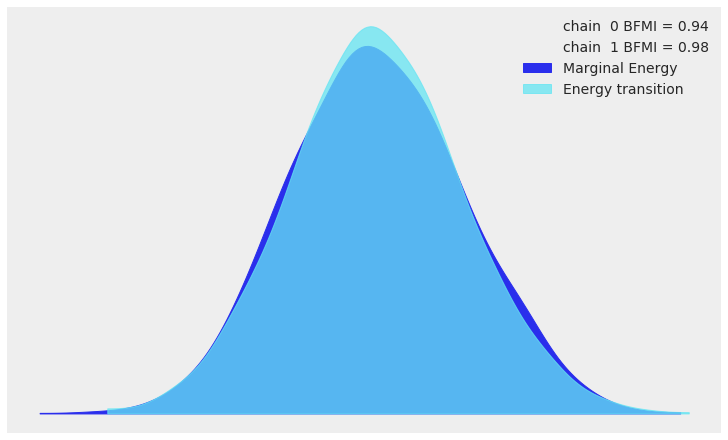

In [27]:
az.plot_energy(trace_gm, figsize=(10, 6));

In [28]:
ppc = pm.sample_posterior_predictive(trace_gm, samples=250, model=model_gm)

100%|██████████| 250/250 [00:02<00:00, 91.98it/s] 


arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.
arviz.data.io_pymc3 - WARNING - posterior predictive shape not compatible with number of chains and draws. This can mean that some draws or even whole chains are not represented.


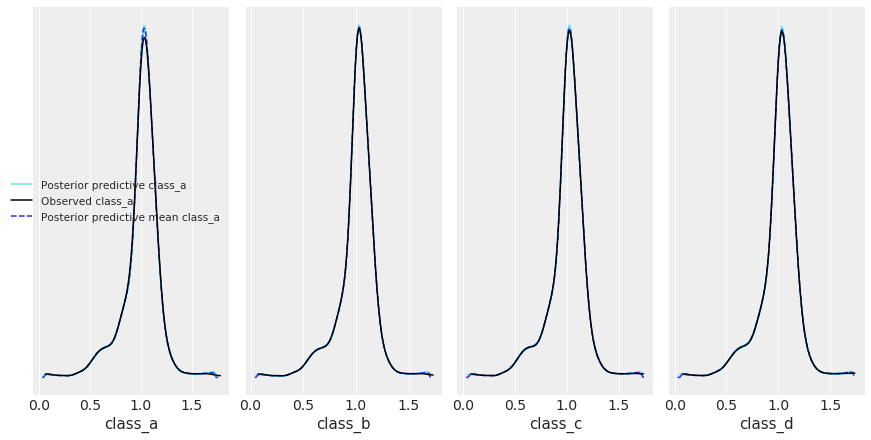

In [29]:
data_ppc = az.from_pymc3(trace=trace_gm, posterior_predictive=ppc)
ax = az.plot_ppc(data_ppc, figsize=(12, 6), mean=True)

In [30]:
print(az.r2_score(x_sa[:len(x_sa)], ppc['class_a']))

r2        0.994925
r2_std    0.000449
dtype: float64


In [31]:
print(az.r2_score(x_sb[:len(x_sb)], ppc['class_b']))

r2        0.994658
r2_std    0.000473
dtype: float64


In [32]:
print(az.r2_score(x_sc[:len(x_sc)], ppc['class_c']))

r2        0.994886
r2_std    0.000459
dtype: float64


In [33]:
print(az.r2_score(x_sd[:len(x_sd)], ppc['class_d']))

r2        0.994563
r2_std    0.000502
dtype: float64


In [34]:
print(az.bfmi(trace_gm))

[0.93673528 0.98059344]


# Posterior samples vs. mean data

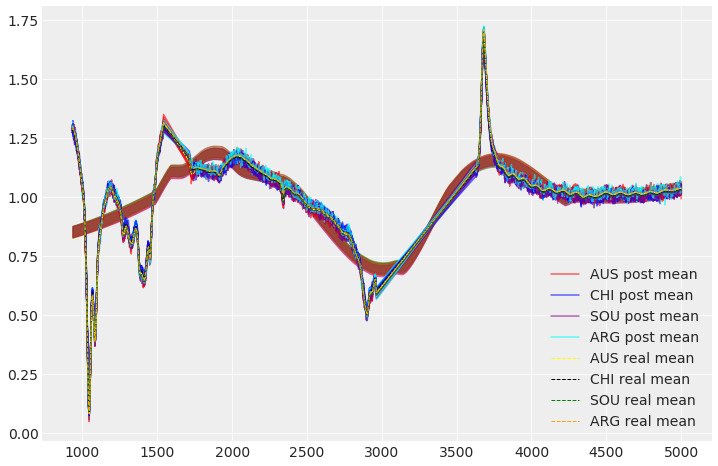

In [41]:
# draw class samples from the posterior
cl_a = ppc['class_a']
cl_b = ppc['class_b']
cl_c = ppc['class_c']
cl_d = ppc['class_d']

# get header data = x-values
cols = data.columns.to_list()
x_val = np.array(cols[:ndata_cols], dtype='float32')

fig = plt.figure(figsize=(12,8))
ax = plt.axes()

# plot some samples from the posterior
for i in range(10):
    plt.plot(x_val, cl_a[i,0,:], '-', color="red", alpha=.6)
    plt.plot(x_val, cl_b[i,0,:], '-', color="blue", alpha=.6)
    plt.plot(x_val, cl_c[i,0,:], '-', color="purple", alpha=.6)
    plt.plot(x_val, cl_d[i,0,:], '-', color="cyan", alpha=.6)

# plot the posterior mean
plt.plot(x_val, cl_a[:,0].mean(axis=0), '-', color="red", alpha=.6, 
         label='AUS post mean')
plt.plot(x_val, cl_b[:,0].mean(axis=0), '-', color="blue", alpha=.6, 
         label='CHI post mean')
plt.plot(x_val, cl_c[:,0].mean(axis=0), '-', color="purple", alpha=.6, 
         label='SOU post mean')
plt.plot(x_val, cl_d[:,0].mean(axis=0), '-', color="cyan", alpha=.6, 
         label='ARG post mean')

# plot mean data for classes (raw data)
df1 = data.loc[data['label'] == clabels[0]]
df2 = data.loc[data['label'] == clabels[1]]
df3 = data.loc[data['label'] == clabels[2]]
df4 = data.loc[data['label'] == clabels[3]]

plt.plot(x_val, df1.iloc[:,:ndata_cols].mean(), '--', color='yellow', 
         label='AUS real mean', linewidth=1)
plt.plot(x_val, df2.iloc[:,:ndata_cols].mean(), '--', color='black', 
         label='CHI real mean', linewidth=1)
plt.plot(x_val, df3.iloc[:,:ndata_cols].mean(), '--', color='green', 
         label='SOU real mean', linewidth=1)
plt.plot(x_val, df4.iloc[:,:ndata_cols].mean(), '--', color='orange', 
         label='ARG real mean', linewidth=1)

# plot 95% HPD interval
az.plot_hpd(x_val, ppc['class_a'], color='C1')
az.plot_hpd(x_val, ppc['class_b'], color='C2')
az.plot_hpd(x_val, ppc['class_c'], color='C3')
az.plot_hpd(x_val, ppc['class_d'], color='C4')

plt.legend(loc='best');

# Real spectrum vs. posterior samples

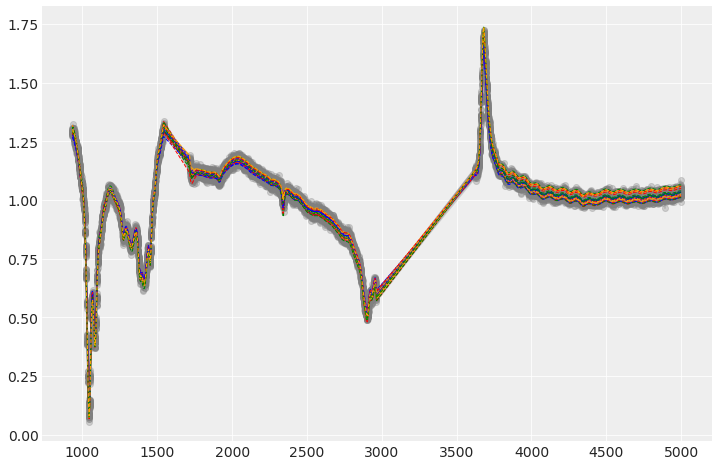

In [42]:
fig = plt.figure(figsize=(12,8))
ax = plt.axes()

# plot some samples from the posterior
for i in range(5):
    plt.plot(x_val, cl_a[i,0,:], 'o-', color="gray", alpha=.3)
    plt.plot(x_val, cl_b[i,0,:], 'o-', color="gray", alpha=.3)
    plt.plot(x_val, cl_c[i,0,:], 'o-', color="gray", alpha=.3)
    plt.plot(x_val, cl_d[i,0,:], 'o-', color="gray", alpha=.3)

# plot mean data for classes (raw data)
df1 = data.loc[data['label'] == clabels[0]].sample(frac=1)
df2 = data.loc[data['label'] == clabels[1]].sample(frac=1)
df3 = data.loc[data['label'] == clabels[2]].sample(frac=1)
df4 = data.loc[data['label'] == clabels[3]].sample(frac=1)
    
for i in range(5):
    plt.plot(x_val, df1.values[i,:ndata_cols], '--', color='red', linewidth=1)
    plt.plot(x_val, df2.values[i,:ndata_cols], '--', color='blue', linewidth=1)
    plt.plot(x_val, df3.values[i,:ndata_cols], '--', color='green', linewidth=1)
    plt.plot(x_val, df4.values[i,:ndata_cols], '--', color='orange', linewidth=1)

# Save posterior samples to .csv file

In [45]:
import csv

samples_per_class = 50
filename = './ppc_samples_wines.csv' 

# create header row
header = np.array(np.around(x_val, 3), dtype='str')
header = header.tolist()
header.append("label")

with open(filename, mode='w') as fp:
    ppc_writer = csv.writer(fp, delimiter=',')
    ppc_writer.writerow(header)
    
    for i in range(samples_per_class):
        row_a = np.array(cl_a[i,0,:], dtype='str').tolist()
        row_a.append(clabels[0])
        row_b = np.array(cl_b[i,0,:], dtype='str').tolist()
        row_b.append(clabels[1])
        row_c = np.array(cl_a[i,0,:], dtype='str').tolist()
        row_c.append(clabels[2])
        row_d = np.array(cl_b[i,0,:], dtype='str').tolist()
        row_d.append(clabels[3])
        ppc_writer.writerow(row_a)
        ppc_writer.writerow(row_b)
        ppc_writer.writerow(row_c)
        ppc_writer.writerow(row_d)